<a href="https://colab.research.google.com/github/Dimildizio/DS_course/blob/main/Neural_networks/GANs/GANs_photos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Generative Adversarial Networks

## Description

GANs are designed for generative tasks, specifically generating new data samples that are similar to a given dataset. The key idea behind GANs is to train two neural networks, a generator, and a discriminator, in a competitive framework


![High Quality Face Image SR Using Conditional Generative Adversarial Networks, 2017](https://www.researchgate.net/publication/318205013/figure/fig3/AS:667700061822978@1536203508077/The-pipeline-of-FCGAN-The-architecture-of-generator-and-discriminator-network-with.jpg)

![clickworker](https://cdn.clickworker.com/wp-content/uploads/2022/11/Generative-Adversarial-Networks-Architecture-scaled.jpg)

### Key features

#### Generator

The generator network takes random noise as input and generates synthetic data samples.

It learns to create data that is indistinguishable from real data in the training set.

#### Discriminator

The discriminator network evaluates input data and attempts to distinguish between real and generated samples.

It is trained to correctly classify samples as either real or fake.

Best score is 0.5 when discriminator confuses fake for real samples

#### Adversarial training

The generator and discriminator are trained simultaneously through adversarial training.

The generator aims to produce realistic samples to fool the discriminator, while the discriminator aims to correctly classify real and generated samples.

#### Training objective

The training objective is a minimax game where the generator tries to minimize the discriminator's ability to distinguish between real and generated samples, and the discriminator tries to maximize its accuracy in distinguishing between them.

#### Convergence

Ideally, this adversarial process leads to a generator that produces high-quality synthetic samples that are difficult for the discriminator to differentiate from real data.

## Imports

In [1]:
%%capture
!pip install torchinfo kaggle wandb

In [2]:
import cv2
import gc
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import seaborn as sns
import torch
import torch.nn as nn
import torchvision.transforms as tt
import wandb
from torchinfo import summary

from google.colab import files, userdata
from pathlib import Path
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid, save_image
from tqdm.notebook import tqdm
from typing import List, Tuple, Dict, Callable
from IPython.display import clear_output

In [3]:
%matplotlib inline
sns.set(style='darkgrid', font_scale=1.2)

## Set Config

In [86]:
class CFG:
  datadir = './faces_dataset_small'
  seed = 42
  batch_size = 32
  imgsize=128
  stats = (0.2, 0.3, 0.3), (0.5, 0.5, 0.5)

  momentum = 0.1
  lr = 1e-5
  gen_lr = 1e-4
  epochs=50
  beta = .999
  weight_decay = 1e-5
  eps=1e-10
  device = lambda: 'cuda' if torch.cuda.is_available() else 'cpu'
  wandbapi = False

wandb_config = lambda: {
    'achitecture':'GAN',
    'optimizer':'AdamW',
    'lr':CFG.lr,
    'batch_size':CFG.batch_size,
    'device':CFG.device(),
}

### Freeze seeds

In [5]:
def seed_everything(seed: int=CFG.seed) -> None:
  np.random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.backends.cudnn.deterministic = True
  #torch.backends.cudnn.benchmark = True

def seed_wrapper(func: Callable) -> Callable:
    """
    A wrapper function for repeatability and reproducibility.

    Args:
        func (Callable): The function to be wrapped.

    Returns:
        Callable: The wrapped function.
    """
    def wrapped_function(*args, **kwargs):
        seed_everything()
        result = func(*args, **kwargs)
        return result
    return wrapped_function

In [6]:
seed_everything()

#### Set WandB

In [ ]:
try:
    CFG.wandbapi = userdata.get('wandb')
    project="GANs"
    entity='dimildizio'
    wandb.login(key=CFG.wandbapi)
except Exception as e:
    print(e)

In [ ]:
def wandb_wrapper(func: Callable) -> Callable:
    """
    A wrapper function for integrating with Weights & Biases (wandb).

    Args:
        func (Callable): The function to be wrapped.

    Returns:
        Callable: The wrapped function.
    """
    def wrapped_function(*args, **kwargs):
        print('wrapper works')
        if CFG.wandbapi:
            wandb.init(project=project, entity=entity, config=wandb_config())
            print('Logging wandb')
        try:
          result = func(*args, **kwargs)
        except Exception as e:
          if CFG.wandbapi:
            wandb.log({"error_message": str(e)}, commit=False)
            wandb.finish()
          raise e
        finally:
          if CFG.wandbapi:
            wandb.finish()
        return result
    return wrapped_function

## Part 1: Data Preparation [2 Points]

### Download data

In [7]:
uploaded = files.upload()
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [8]:
%%capture
!kaggle datasets download -d tommykamaz/faces-dataset-small

In [9]:
%%capture
!unzip faces-dataset-small.zip

In [10]:
image_files = sorted(list(Path(CFG.datadir).rglob('*.png')))

#### Get statistics
The stats - means and stds given to us are pretty fkd up, so let figure aout what are the stats for first [batchsize] photos and use them

In [11]:
class CustomDataset(Dataset):
    def __init__(self):
        self.root_dir = CFG.datadir
        self.images = [f for f in os.listdir(self.root_dir) if f.endswith('.png')]
        self.transform = transforms.Compose([transforms.Resize(CFG.imgsize),
                         transforms.CenterCrop(CFG.imgsize),
                         transforms.ToTensor(),
                         transforms.Normalize(*CFG.stats)])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.images[idx])
        image = Image.open(img_name)
        image = self.transform(image)
        return image

In [12]:
def get_stats(dataset):

  loader = DataLoader(dataset, batch_size=256, num_workers=1)
  data = next(iter(loader))
  mean = data.mean(dim=(0, 2, 3))
  std = data.std(dim=(0, 2, 3))

  print("Mean: ", mean)
  print("Std: ", std)
  return mean, std

In [13]:
custom_dataset = CustomDataset()
mean, std = get_stats(custom_dataset)
CFG.stats = mean, std
gc.collect()

Mean:  tensor([ 0.0534, -0.1315, -0.2255])
Std:  tensor([0.5565, 0.5031, 0.5027])


34

### Show images

In [14]:
def denorm(img_tensors):
    return img_tensors * CFG.stats[1][0] + CFG.stats[0][0]

In [15]:
perm = lambda x: CustomDataset().transform(x).permute(1,2,0)

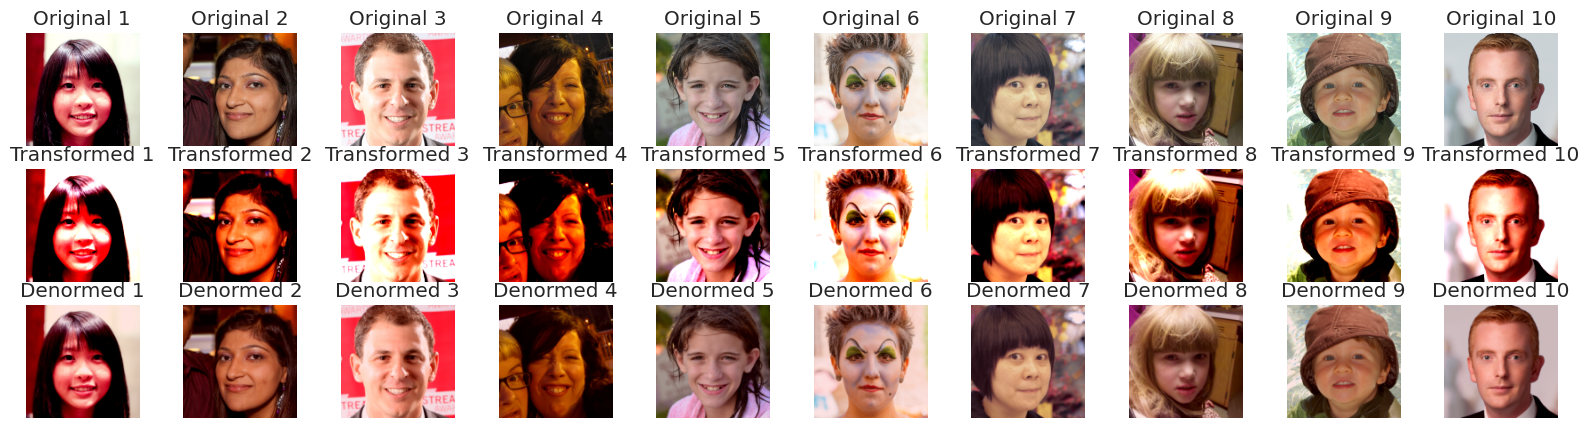

In [22]:
first_x = 10
original_images = [Image.open(image) for image in image_files[:first_x]]
transformed_images = [perm(x) for x in original_images]
denormed_transformed_images = [denorm(x) for x in transformed_images]

axdict = {0: ('Original', original_images),
          1:('Transformed', transformed_images),
          2: ('Denormed', denormed_transformed_images)}

fig, axes = plt.subplots(3, first_x, figsize=(20, 5))
for i in range(first_x):
  for key, value in axdict.items():
    axes[key, i].imshow(value[1][i])
    axes[key, i].set_title(f"{value[0]} {i+1}")
    axes[key, i].axis("off")
plt.show()

Normalization changes the colors\contrast of images.

## Load data

In [23]:
train_dl = DataLoader(CustomDataset(), CFG.batch_size, shuffle=True, num_workers=2, pin_memory=True)

In [24]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [25]:
dataloader = DeviceDataLoader(train_dl, CFG.device())
del train_dl

## Part 2: Model architecture and training [2 points]

### Generator description

#### Description

Generator is responsible for creating new, synthetic data samples that resemble real data. It takes random noise as input and transforms it into data instances that ideally are indistinguishable from real data.

#### Generative Loss

The generator aims to produce samples that are convincing enough to fool the discriminator. It is trained using an adversarial loss, encouraging generated samples to be classified as real.

#### Random Noise Input

The generator takes random noise as input and transforms it into data samples. This noise is a key factor in producing diverse outputs.

#### Architectural Symmetry

The architecture of the generator is often designed to mirror that of the discriminator, promoting symmetry in the GAN model.

#### Transferable Features

As the generator improves, it learns to capture high-level features and structures present in the real data, making the generated samples more realistic.








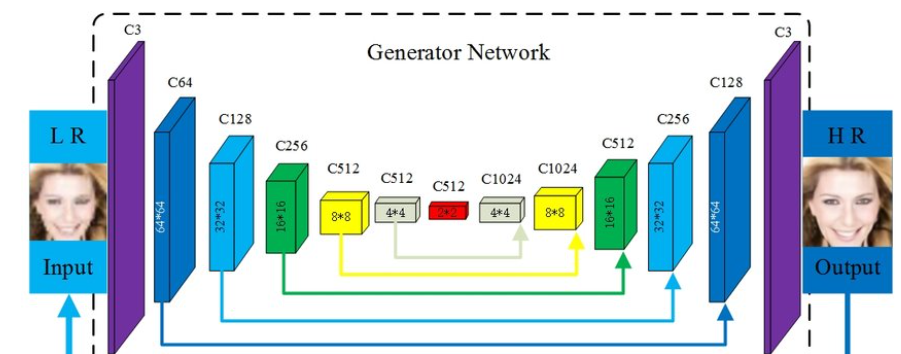


[High Quality Face Image SR Using Conditional Generative Adversarial Networks, 2017](https://www.researchgate.net/publication/318205013_High-Quality_Face_Image_SR_Using_Conditional_Generative_Adversarial_Networks?_tp=eyJjb250ZXh0Ijp7ImZpcnN0UGFnZSI6Il9kaXJlY3QiLCJwYWdlIjoiX2RpcmVjdCJ9fQ)

### Generator architecture

In [95]:
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()
    self.ouch_1 = CFG.imgsize * 8
    self.ouch_2 = self.ouch(self.ouch_1)
    self.ouch_3 = self.ouch(self.ouch_2)
    self.ouch_4 = self.ouch(self.ouch_3)
    self.ouch_5 = self.ouch(self.ouch_4)


    self.n_layers = nn.Sequential(
        self.get_layer(CFG.imgsize, self.ouch_1, stride=1, padding=0),  # 1024
        self.get_layer(self.ouch_1, self.ouch_2),                       # 512
        self.get_layer(self.ouch_2, self.ouch_3),                       # 256
        self.get_layer(self.ouch_3, self.ouch_4),                       # 128
        self.get_layer(self.ouch_4, self.ouch_5),                       # 64
        self.get_final_layer(),)                                        # 3
    self.apply(self.weights_init)

  def ouch(self, n):
    return n//2


  def get_final_layer(self):
    layer = nn.Sequential(
                  nn.ConvTranspose2d(in_channels=self.ouch_5, out_channels=3,
                                     kernel_size=4, stride=2, padding=1),
                  nn.Tanh(),)
    return layer


  def get_layer(self, inch, ouch, kernel=4, stride=2, padding=1):
    layer = nn.Sequential(
        nn.ConvTranspose2d(in_channels=inch, out_channels=ouch, kernel_size=kernel,
                           stride=stride, padding=padding, bias=False),
        nn.BatchNorm2d(num_features=ouch, momentum=CFG.momentum),
        nn.LeakyReLU(negative_slope=0.2))
    return layer


  def weights_init(self, layer):
    if isinstance(layer, (nn.Conv2d, nn.ConvTranspose2d)):
      nn.init.normal_(layer.weight.data, 0.0, 0.02)
    elif isinstance(layer, nn.BatchNorm2d):
      nn.init.normal_(layer.weight.data, 1.0, 0.02)
      nn.init.constant_(layer.bias.data, 0)



  def forward(self, x):
    return self.n_layers(x)

### Discriminator

#### Description

Discriminator acts as a critical component in the adversarial training process. It learns to distinguish between real and generated data, and its feedback guides the generator to produce more realistic samples. The interplay between the generator and discriminator is what drives GANs to generate high-quality synthetic data that closely resembles real data distributions.

Its primary role is to assess the authenticity of input data samples and distinguish between real and generated data.


#### Binary Classification

The discriminator performs binary classification, determining whether a given input is real or generated.

####Convolutional Layers

Convolutional neural network (CNN) layers are commonly used in the discriminator to effectively capture spatial features in images.

#### Discriminative Loss

The discriminator is trained to minimize a binary cross-entropy loss, penalizing incorrect classifications.

#### Adversarial Training

The discriminator learns to become increasingly accurate in distinguishing between real and generated samples during adversarial training.

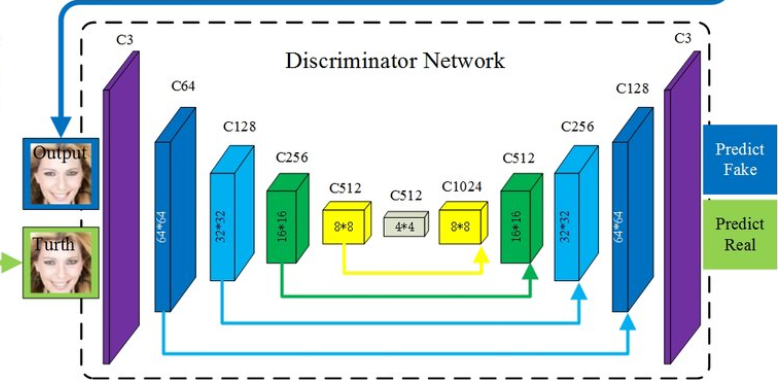


[High Quality Face Image SR Using Conditional Generative Adversarial Networks, 2017](https://www.researchgate.net/publication/318205013_High-Quality_Face_Image_SR_Using_Conditional_Generative_Adversarial_Networks?_tp=eyJjb250ZXh0Ijp7ImZpcnN0UGFnZSI6Il9kaXJlY3QiLCJwYWdlIjoiX2RpcmVjdCJ9fQ)

### Discriminator architecture

In [73]:
class Noise(nn.Module):
  def forward(self, x):
    return x+torch.empty_like(x).normal_(std=0.1) if self.training else x


class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.ouch_1 = CFG.imgsize //2
    self.ouch_2 = self.ouch(self.ouch_1)
    self.ouch_3 = self.ouch(self.ouch_2)
    self.ouch_4 = self.ouch(self.ouch_3)
    self.ouch_5 = self.ouch(self.ouch_4)

    self.n_layers = nn.Sequential(
        self.get_layer(3, self.ouch_1),           # 64
        self.get_layer(self.ouch_1, self.ouch_2), # 128
        self.get_layer(self.ouch_2, self.ouch_3), # 256
        self.get_layer(self.ouch_3, self.ouch_4), # 512
        self.get_layer(self.ouch_4, self.ouch_5), # 1024
        self.get_final_layer(),)                  # True\False
    self.apply(self.weights_init)

  def ouch(self, n):
    return n*2


  def get_final_layer(self):
    layer = nn.Sequential(
        Noise(),
        nn.Conv2d(in_channels=self.ouch_5, out_channels=1,
                  kernel_size=4, stride=1, padding=0, bias=False),
        nn.Flatten(),
        nn.Sigmoid(),)
    return layer


  def get_layer(self, inch, ouch, kernel=4, stride=2, padding=1):
    layer = nn.Sequential(
        Noise(),
        nn.Conv2d(in_channels=inch, out_channels=ouch, kernel_size=kernel,
                           stride=stride, padding=padding, bias=False),
        nn.BatchNorm2d(num_features=ouch, momentum=CFG.momentum),
        nn.LeakyReLU(negative_slope=0.2))
    return layer


  def weights_init(self, layer):
    if isinstance(layer, (nn.Conv2d, nn.ConvTranspose2d)):
      nn.init.normal_(layer.weight.data, 0.0, 0.02)
    elif isinstance(layer, nn.BatchNorm2d):
      nn.init.normal_(layer.weight.data, 1.0, 0.02)
      nn.init.constant_(layer.bias.data, 0)


  def forward(self, x):
    return self.n_layers(x)

Check if the dimensions are right

In [69]:
summary(Generator(), (CFG.batch_size, CFG.imgsize, 1, 1))

torch.Size([32, 128, 1, 1])


Layer (type:depth-idx)                   Output Shape              Param #
Generator                                [32, 3, 128, 128]         --
├─Sequential: 1-1                        [32, 3, 128, 128]         --
│    └─Sequential: 2-1                   [32, 1024, 4, 4]          --
│    │    └─ConvTranspose2d: 3-1         [32, 1024, 4, 4]          2,097,152
│    │    └─BatchNorm2d: 3-2             [32, 1024, 4, 4]          2,048
│    │    └─LeakyReLU: 3-3               [32, 1024, 4, 4]          --
│    └─Sequential: 2-2                   [32, 512, 8, 8]           --
│    │    └─ConvTranspose2d: 3-4         [32, 512, 8, 8]           8,388,608
│    │    └─BatchNorm2d: 3-5             [32, 512, 8, 8]           1,024
│    │    └─LeakyReLU: 3-6               [32, 512, 8, 8]           --
│    └─Sequential: 2-3                   [32, 256, 16, 16]         --
│    │    └─ConvTranspose2d: 3-7         [32, 256, 16, 16]         2,097,152
│    │    └─BatchNorm2d: 3-8             [32, 256, 16, 16]

In [74]:
summary(Discriminator(), (CFG.batch_size, 3, CFG.imgsize, CFG.imgsize))

Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            [32, 1]                   --
├─Sequential: 1-1                        [32, 1]                   --
│    └─Sequential: 2-1                   [32, 64, 64, 64]          --
│    │    └─Noise: 3-1                   [32, 3, 128, 128]         --
│    │    └─Conv2d: 3-2                  [32, 64, 64, 64]          3,072
│    │    └─BatchNorm2d: 3-3             [32, 64, 64, 64]          128
│    │    └─LeakyReLU: 3-4               [32, 64, 64, 64]          --
│    └─Sequential: 2-2                   [32, 128, 32, 32]         --
│    │    └─Noise: 3-5                   [32, 64, 64, 64]          --
│    │    └─Conv2d: 3-6                  [32, 128, 32, 32]         131,072
│    │    └─BatchNorm2d: 3-7             [32, 128, 32, 32]         256
│    │    └─LeakyReLU: 3-8               [32, 128, 32, 32]         --
│    └─Sequential: 2-3                   [32, 256, 16, 16]         --
│    

### Training process

In [75]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [76]:
latent_size = 128
#fixed_latent = torch.randn(64, latent_size, 1, 1, device=CF.device())

In [77]:
def save_samples(index, generator, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [78]:
class Model:
  def __init__(self, model, lr):
    self.model = model().to(CFG.device())
    self.criterion = nn.BCELoss()
    self.optimizer = torch.optim.AdamW(self.model.parameters(),
                                      lr=lr, betas=(CFG.beta/2, CFG.beta),
                                      eps=CFG.eps, weight_decay=CFG.weight_decay)
    self.scheduler = torch.optim.lr_scheduler.MultiStepLR(self.optimizer,
                    gamma=0.8, milestones=[CFG.epochs//4, CFG.epochs//2,
                                            CFG.epochs//1.5, CFG.epochs//1.1])
    self.loss_history = []

  def add_history(self, score):
    self.loss_history.append(np.mean(score))

In [79]:
class Scores:
  def __init__(self):
    self.run_epoch_scores()

  def run_epoch_scores(self):
    self.dscr_loss = []
    self.gen_loss  = []
    self.real_score = []
    self.fake_score = []

  def get_cur_score(self, score, name):
    score = torch.mean(score).item()
    if name == 'real':
      self.real_score.append(score)
    else:
      self.fake_score.append(score)

  def add_loss(self, loss, name):
    loss = loss.item()
    if name == 'gen':
      self.gen_loss.append(loss)
    else:
      self.dscr_loss.append(loss)

  @property
  def epoch_real_score(self):
    return np.mean(self.real_score)

  @property
  def epoch_fake_score(self):
    return np.mean(self.fake_score)

  @staticmethod
  def get_last(n):
    return f"{n[-1]:.4f}"


In [118]:
def show_images(imgs, epoch, gen_history, dscr_history, score_history, rows=8):
    clear_output(wait=True)
    fig, ax = plt.subplots(figsize=(12, 8))

    fig.suptitle((f"Epoch [{epoch+1}/{CFG.epochs}], \
          gen_loss: {gen_history}, \
          dscr_loss: {dscr_history}, \
          real score: {score_history['real_score'][-1]}, \
          fake score: {score_history['fake_score'][-1]}"))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(denorm(imgs.cpu().detach()), nrow=rows).permute(1, 2, 0))

In [117]:
def fit(data_loader, dscr, gen, score_history, start_idx=1):
  for mod in [dscr, gen]:
    mod.model.train()
  torch.cuda.empty_cache()

  for epoch in range(CFG.epochs):
    print(f'Epoch: {epoch+1}/{CFG.epochs}')
    scores = Scores()
    for real_images in tqdm(data_loader):
      # Train discriminator
      # Clear discriminator gradients
      dscr.optimizer.zero_grad()

      # Pass real images through discriminator
      real_preds = dscr.model(real_images)
      real_targets = torch.rand(real_images.size(0), 1, device=CFG.device()) *0.05 + 0.95  #0-5% Noise augmentation
      real_loss = dscr.criterion(real_preds, real_targets)
      scores.get_cur_score(real_preds, 'real')

      # Generate fake images
      latent = torch.randn(CFG.batch_size, CFG.imgsize, 1, 1, device=CFG.device())
      fake_images = gen.model(latent)

      # Pass fake images through discriminator
      fake_targets = torch.rand(fake_images.size(0), 1, device=CFG.device()) *0.05
      fake_preds = dscr.model(fake_images)
      fake_loss = dscr.criterion(fake_preds, fake_targets)
      scores.get_cur_score(fake_preds, 'fake')

      # Update discriminator weights
      loss_d = real_loss + fake_loss
      loss_d.backward()
      dscr.optimizer.step()
      scores.add_loss(loss_d, 'dscr')

      # Train generator
      # Clear generator gradients
      gen.optimizer.zero_grad()

      # Generate fake images
      latent = torch.randn(CFG.batch_size, CFG.imgsize, 1, 1, device=CFG.device())
      fake_images = gen.model(latent)

      # Try to fool the discriminator
      preds = dscr.model(fake_images)
      targets = torch.ones(CFG.batch_size, 1, device=CFG.device())
      loss_g = gen.criterion(preds, targets)

      # Update generator weights
      loss_g.backward()
      gen.optimizer.step()
      scores.add_loss(loss_g, 'gen')

    # Record losses & scores
    gen.add_history(scores.gen_loss)
    dscr.add_history(scores.dscr_loss)

    score_history['real_score'].append(scores.epoch_real_score)
    score_history['fake_score'].append(scores.epoch_fake_score)

    for mod in (dscr, gen):
      mod.scheduler.step()

    # Visualisations

    show_images(fake_images, epoch, gen.loss_history[-1], dscr.loss_history[-1], score_history)
    print(f"real_score:{score_history['real_score']}\nfake_score: {score_history['fake_score']}")
    print(f"gen loss: {gen.loss_history[-1]}\ndscr loss: {dscr.loss_history[-1]}")


    # Save generated images
    if epoch == CFG.epochs - 1:
      fixed_latent = torch.randn(CFG.batch_size, CFG.imgsize, 1, 1, device=CFG.device())
      save_samples(gen.model, epoch+start_idx, fixed_latent, show=False)

  return score_history

In [120]:
score_history = {'fake_score':[], 'real_score':[]}
dscr = Model(Discriminator, CFG.lr)
gen = Model(Generator, CFG.gen_lr)

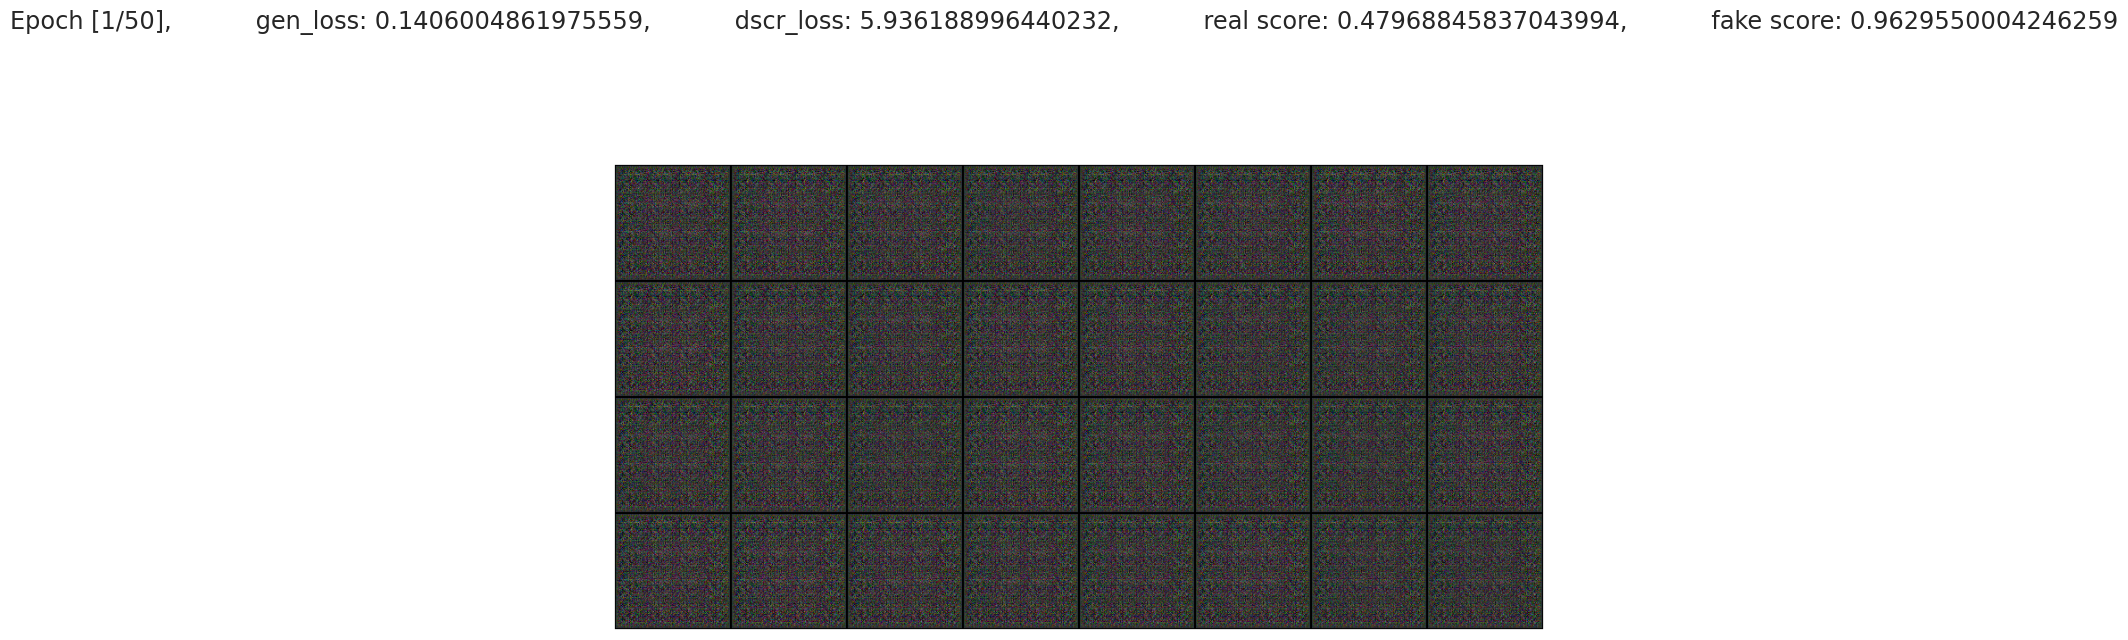

In [119]:
latent = torch.randn(CFG.batch_size, CFG.imgsize, 1, 1, device=CFG.device())
fake_images = gen.model(latent)
show_images(fake_images, 0, gen.loss_history[-1], dscr.loss_history[-1], score_history)

In [ ]:
new_history = fit(dataloader, dscr, gen, score_history)

Epoch: 1/50


  0%|          | 0/99 [00:00<?, ?it/s]